# Lab session 7: outlier detection

## Introduction

The purpose of this lab session is to provide you with an opportunity to gain experience in **outlier detection** using typical Python libraries.

This session starts with a tutorial that uses examples to introduce you to the practical knowledge that you will need for the corresponding assignment. We highly recommend that you read the following tutorials if you need a gentler introduction to the libraries that we use:
- [Numpy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html)
- [Numpy: basic broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)
- [Matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html)
- [Seaborn](https://seaborn.pydata.org/tutorial/relational.html)
- [Scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)

## Submission instructions

- The last section of this notebook includes the first part of the assessed assignment for day 4.
- There will be 4 assessed assignments. Each assignment corresponds to 10% of your final grade.
- The exam corresponds to the remaining 60% of your final grade.
- **PLAGIARISM** <ins>leads to irreversible non-negotiable failure in the module</ins> (if you are unsure about what constitutes plagiarism, please ask). 
- The deadline for submitting each assignment is defined on QM+.
- Penalties for late submissions will be applied in accordance with the School policy. The submission cut-off date is 7 days after the deadline.
- You should submit a **report** with your solutions to the assignment included in the last section of this notebook. The report should be a single **pdf** file. Other formats (such as doc, docx, or ipynb) are **not** acceptable. 
- The report should be excellently organized and identified with your name, student number, assignment number, and module identifier. When applicable, question numbers should precede the corresponding answers. 
- Please name your report file according to the following convention: Assignment[Number]-[Student Name]-[Student Number].pdf
- Submissions should be made through QM+. Submissions by e-mail will be ignored.
- Please always check whether the report file was uploaded correctly to QM+.
- Cases of **extenuating circumstances** have to go through the proper procedure in accordance with the School policy. Only cases approved by the School in due time will be considered.

## 1. Outlier detection using parametric methods 

This approach assumes that the majority of the observations are drawn from a well-known probability distribution, e.g., a Gaussian distribution. Outliers can then be detected by seeking for observations that do not fit the overall distribution of the data. 

In this example, our goal is to detect anomalous changes in the daily closing prices of various stocks. The input data **data/stocks.csv** contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). 

In [1]:
import pandas as pd

# Load CSV file, set the 'Date' values as the index of each row, and display the first rows of the dataframe
stocks = pd.read_csv('stocks.csv', header='infer') 
stocks.index = stocks['Date']
stocks = stocks.drop(['Date'],axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on the previous day, $t-1$.

In [2]:
import numpy as np

N,d = stocks.shape
# Compute delta, which denotes the percentage of changes in the daily closing price of each stock
delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values - stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


We can now plot the distribution of the percentage daily changes in stock price as a 3-dimensional scatter plot:

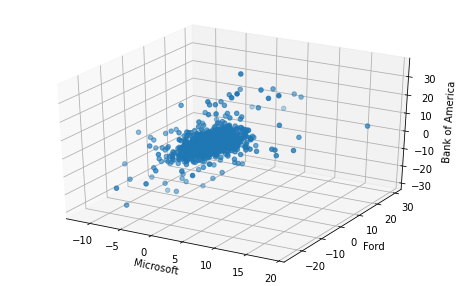

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5)).gca(projection='3d')
fig.scatter(delta.MSFT,delta.F,delta.BAC)
fig.set_xlabel('Microsoft')
fig.set_ylabel('Ford')
fig.set_zlabel('Bank of America')

plt.show()

Let's assume that the ``delta`` data follows a multivariate (i.e. multidimensional) Gaussian distribution. Such a probability distribution can be characterised by two statistics: the mean and covariance matrix of the 3-dimensional data. 

We can then compute the mean and covariance matrix of the 3-dimensional ``delta`` data (which represent the percentage of changes in the daily closing price of each stock). Then, to determine the anomalous trading days, we can compute the **Mahalanobis distance** between the percentage of price change on each day against the mean percentage of price change:
\begin{equation}
\textrm{M}(x,\bar{x}) = \sqrt{(x - \bar{x})^T S^{-1}(x - \bar{x})}
\end{equation}
where $x$ is assumed to be a column vector, $\bar{x}$ denotes the mean vector, and $S$ denotes the covariance matrix of the data.


In [9]:
from numpy.linalg import inv

def mahalanobis(x=None, data=None):
    x_mu = x - np.mean(data)
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    
    right = np.matmul(inv_covmat, x_mu.T)
    mahal = np.sum(x_mu*right.T, axis=1)
    return np.sqrt(mahal)

Then, we can call the created function for the Mahalanobis distance on the 'delta' dataframe containing the daily percentage changes for each stock:

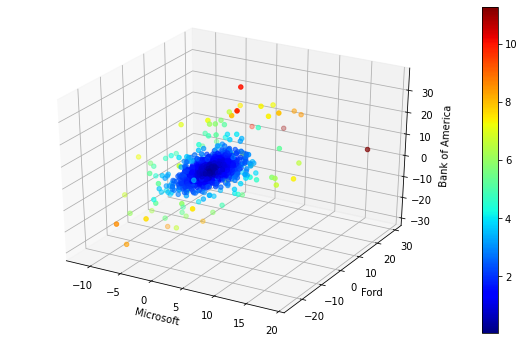

In [41]:
# Compute Mahalanobis distance for delta dataset
mahal = mahalanobis(x=delta, data=delta[['MSFT', 'F', 'BAC']])

# Assign an outlier score for the data based on the computed Mahalanobis distance
outlier_score = mahal

# Display 3D scatterplot with observations having a different color according to their outlier score
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The top outliers are shown as the dark red and orange points in the above scatterplot. We can examine the dates associated with the top-5 highest outlier scores as follows:

In [ ]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,11.269084
11/26/2008,2.501251,29.518072,4.256757,11.016388
4/9/2009,2.501297,7.341772,35.269122,10.023290
11/28/2008,-1.317721,25.116279,5.314323,9.905421
1/21/2009,4.870124,-1.877934,30.980392,9.779085


We see for example that the top outlier was detected for 13th October 2008. This was a period of economic instability due to the 2008 global financial crisis (https://en.wikipedia.org/wiki/Global_financial_crisis_in_October_2008).

We can subsequently inspect stocks around the top-2 outlier dates for each company, and see to which compani(es) are these outliers attributed to.

Text(0, 0.5, 'Percent Change')

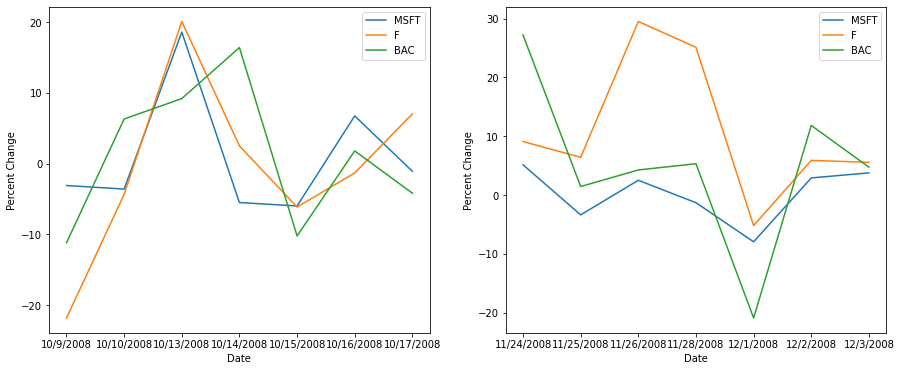

In [19]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ts = delta[445:452]
ts.plot.line(ax=ax1)
ax1.set_xticks(range(7))
ax1.set_xticklabels(ts.index)
ax1.set_ylabel('Percent Change')

ts = delta[477:484]
ts.plot.line(ax=ax2)
ax2.set_xticks(range(7))
ax2.set_xticklabels(ts.index)
ax2.set_ylabel('Percent Change')

## 2. Outlier detection using proximity-based approaches

This is a model-free outlier detection approach which does not require constructing an explicit model of the normal class to determine the outlier score of observations. The example code shown below employs the k-nearest neighbor approach to calculate the outlier score. Specifically, a normal observation is expected to have a small distance to its k-th nearest neighbour whereas an outlier is likely to have a large distance to its k-th nearest neighbour. In the example below, we apply the distance-based approach with $k=4$ to identify the anomalous trading days from the stock market data described in the previous section.

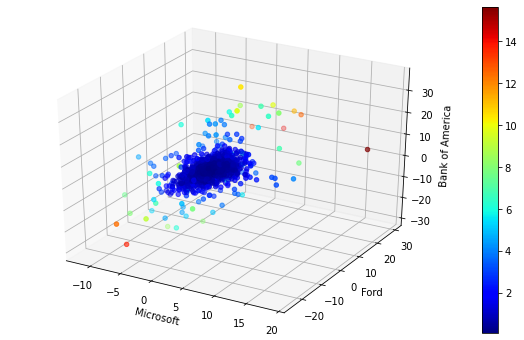

In [42]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

# Implement a k-nearest neighbour approach using k=4 neighbours
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(delta.values)
distances, indices = nbrs.kneighbors(delta.values)

# The outlier score is set as the distance between the observation and its k-th nearest neighbour
outlier_score = distances[:,knn-1]

# Plot 3D scatterplot of outlier scores
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(delta.MSFT,delta.F,delta.BAC,c=outlier_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
fig.colorbar(p)
plt.show()

The results are slightly different than those shown in Section 1 due to the difference distance used (Euclidean distance vs Mahalanobis distance) and the proximity criterion to detect the outliers. 

We can examine the dates associated with the top-5 highest outlier scores as follows. 

In [35]:
outlier = pd.DataFrame(outlier_score, index=delta.index, columns=['Outlier score'])
result = pd.concat((delta,outlier), axis=1)
result.nlargest(5,'Outlier score')

,MSFT,F,BAC,Outlier score
Date,,,,
10/13/2008,18.604651,20.100503,9.199808,15.642827
11/26/2008,2.501251,29.518072,4.256757,14.212749
10/7/2008,-6.744279,-20.867209,-26.225949,13.751302
11/28/2008,-1.317721,25.116279,5.314323,13.139586
9/30/2008,6.717317,24.700240,15.702479,12.599739


Finally, similarly to the analysis carried out in Section 1, we can inspect stock prices around those outlier dates for each company. The figure below presents the delta values for each company around the date of the 3rd detected outlier, 7th October 2008, which represents a key date for the 2008 financial recession. Two companies seem to be primarily responsible for the creation of this outlier.

Text(0, 0.5, 'Percent Change')

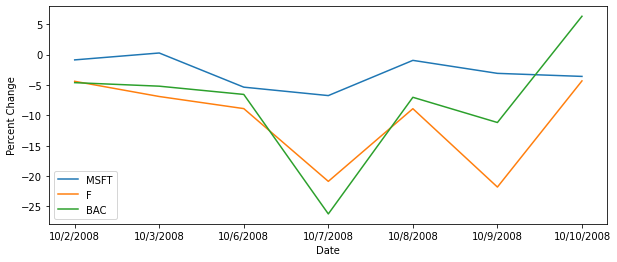

In [ ]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ts = delta[440:447]
ts.plot.line(ax=ax)
ax.set_xticks(range(7))
ax.set_xticklabels(ts.index)
ax.set_ylabel('Percent Change')

## 3.0 Outlier detection using classification-based methods

The **support vector machine (SVM)** was initially developed for binary classification, but can be used for one-class classification, and therefore for outlier detection.

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as **One-Class SVM**.

In this section, we will work with a different dataset on house prices available at https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv . This dataset has 13 input variables that describe the properties of the house and suburb and requires the prediction of the median value of houses in the suburb in thousands of dollars. Information and metadata about the dataset can be found at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.names . Please spend some time to inspect the dataset and its metadata.

As a first step, we load the dataset and split it into input and output (target) elements:

In [68]:
from pandas import read_csv

# Loading the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)

# Extracting the values from the dataframe
data = df.values

# Split dataset into input and output elements
X, y = data[:, :-1], data[:, -1]


# Summarize the shape of the dataset
print(X.shape, y.shape)

(506, 13) (506,)


Using the OneClassSVM() function in scikit-learn, we can initialise and train an one-class SVM classifier on the input data. Please study the [OneClassSVM() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) for information on input arguments. 

We can then print the predicted labels. The label -1 represents outliers and the label 1 represents inliers (i.e., observations that are considered normal).

In [69]:
from sklearn.svm import OneClassSVM

ee = OneClassSVM(nu=0.01, gamma='auto')
yhat = ee.fit_predict(X) # Perform fit on input data and returns labels for that input data.

print(yhat) # Print labels: -1 for outliers and 1 for inliers.

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1
  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1  1
 -1 -1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1
 -1  1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1
  1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1  1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1 -1  1 -1  1  1 -1 -1 -1
  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1
 -1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1

Having trained the one-class SVM, we can then select all rows from the dataset that are **not** outliers:

In [70]:
# Select all rows that are not outliers
mask = yhat != -1
X, y = X[mask, :], y[mask]

# Summarize the shape of the updated dataset
print(X.shape, y.shape)

(190, 13) (190,)


As we see, the new dataset has a significantly smaller number of observations, all of which are considered normal by the one-class SVM.

## Assignment 4 [Part 1/2]

1. For an application on credit card fraud detection, we are interested in detecting contextual outliers. Suggest 2 possible contextual features and 2 possible behavioural features that could be used for this application, and explain why each of your suggested features should be considered as either contextual or behavioural. [0.5/5]

3. The monthly rainfall in the London borough of Tower Hamlets was measured (in mm) from January-December 2018: {22.93, 20.59, 25.65, 23.74, 25.24, 4.55, 23.45, 28.18, 23.52, 22.32, 26.73, 23.42}. Assuming that the sample is iid according to a univariate Gaussian distribution, identify outlier values in the dataset above using the maximum likelihood method. Is the assumption about the distribution reasonable? [1.5/5]

4. Suppose that you are provided with the graduation rate dataset used in Lab 3 (``data/graduation_rate.csv``). For the ``high school gpa`` feature, compute the relative frequency  of each value (i.e., number of occurrences divided the size of the dataset). Show these computed relative frequencies in your report. Suppose that two new observations are included in the dataset, one with a ``high school gpa`` value of $3.6$, and one with a ``high school gpa`` value of $2.8$. Which of the two new observations is an outlier and why? [1.5/5]

5. Using the stock prices dataset considered in Sections 1 and 2, estimate the outliers in the dataset using the one-class SVM classifier approach. As input to the classifier, use the percentage of changes in the daily closing price of each stock, as done in Section 1. Plot a 3D scatterplot of the dataset where each observation is coloured according to whether it is an outlier or an inlier. Based on the plot, how does the one-class SVM approach for outlier detection differ from the parametric and proximity-based methods presented in Sections 1 and 2? What percentage of the observations are classified as outliers? [1.5/5]
